# Explainable Anomaly Detection

Shapley Values of Reconstruction Errors of PCA for Explaining Anomaly Detection. 

### Read data

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/selected_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [2]:
df.shape

(10014, 39)

In [3]:
df.head()

,Flow rate_kurtosis,Zone3_Pressure_count_above_mean,Zone4_Pressure_count_above_mean,Zone5_Pressure_minimum,Zone6_Pressure_count_below_mean,Zone7_Pressure_minimum,Zone7_Pressure_count_below_mean,Zone7_Pressure_skewness,Zone9_Pressure_mean,Zone9_Pressure_kurtosis,...,Zone22_Pressure_count_below_mean,Zone23_Pressure_count_below_mean,Zone24_Pressure_kurtosis,Zone24_Pressure_count_below_mean,Zone24_Pressure_count_above_mean,Zone24_Pressure_skewness,Zone26_Pressure_count_above_mean,Zone29_Pressure_count_above_mean,Zone31_Pressure_count_below_mean,target
0,-0.568486,330,364,-2038.22,543,-1057.16,618,1.588478,7272.842730,5.311404,...,440,560,5.167330,708,149,2.473288,247,376,619,1
1,-0.507464,336,371,-2038.22,541,-1040.04,624,1.623811,7826.292369,5.748566,...,443,557,5.368426,717,144,2.516752,247,378,623,0
2,-0.766407,331,388,-1964.60,572,-1006.84,658,1.841518,7669.570471,7.946121,...,504,595,11.189778,749,143,3.445868,288,424,644,1
3,-0.712796,378,364,-2038.22,582,-1032.48,625,1.680860,9924.194251,2.121459,...,486,590,17.256859,721,182,3.720973,272,370,625,0
4,-0.504741,334,330,-1898.18,604,-1380.96,674,2.272728,3717.180958,9.245656,...,549,609,7.990006,722,217,2.840404,314,408,654,0


In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

### Utils

In [5]:
seed = 0

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(max_depth=10, n_estimators=100, random_state=seed)

def print_classification_report(X, y):   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed, stratify=y)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [7]:
print_classification_report(X, y)

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1637
           1       0.77      0.83      0.80      1668

    accuracy                           0.79      3305
   macro avg       0.79      0.79      0.78      3305
weighted avg       0.79      0.79      0.79      3305



### Anomaly/Outlier detection with PCA reconstruction

Standarize and split the data on train/test.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Standardize features by removing the mean and scaling to unit variance

X_standar = pd.DataFrame(StandardScaler().fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X_standar, y, test_size=0.33, random_state=seed, stratify=y)

Fit pca

In [9]:
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=0.95).fit(X_train)

print(pca.singular_values_)  

[255.3358511  213.28110997 159.60934738 137.27479854 116.51328414
 100.21405881  92.41160149  79.25169467  73.5188137   66.44947167
  62.29403158  59.55622465  56.68484567  54.75847869  47.35316792
  45.90020303  42.8918319   41.83955728]


Transform and reconstruct the data.

In [10]:
# Transform
X_train_transf = pca.fit_transform(X_train)
X_test_transf = pca.transform(X_test)

# Reconstruct
X_train_reconstr = pca.inverse_transform(X_train_transf)
X_test_reconstr = pca.inverse_transform(X_test_transf)

Calculate the reconstruction error.

In [11]:
# Reconstruccion error(MAE)
error_train = X_train - X_train_reconstr
error_test = X_test - X_test_reconstr

In [12]:
train_mean_error = error_train.abs().mean()
test_mean_error = error_test.abs().mean()

#train_mean_error = (error_train**2).mean()
#test_mean_error = (error_test**2).mean()

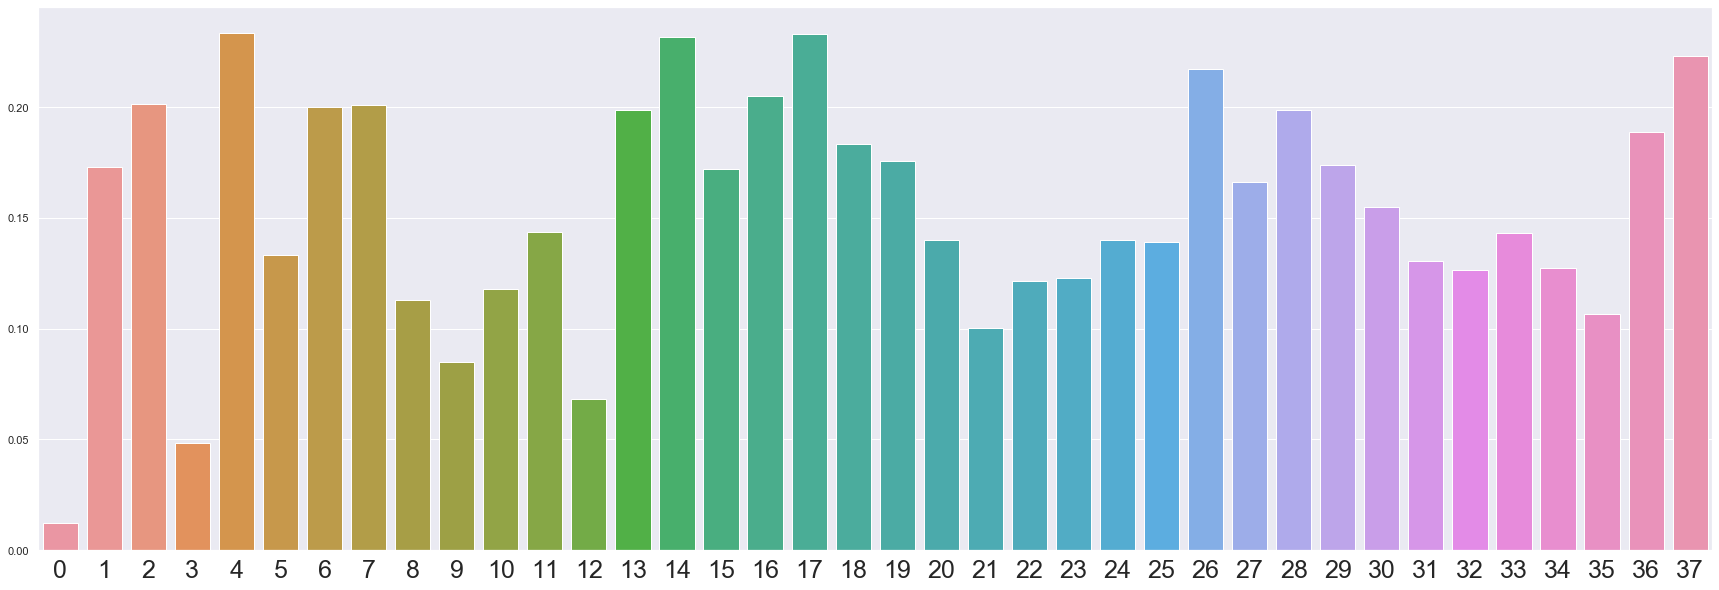

In [14]:
# Plot each feature reconstruction error.
import seaborn as sns

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(30,10)})

ax = sns.barplot(x=train_mean_error.index, y=train_mean_error.values)
ax = ax.set_xticklabels(train_mean_error.index, rotation=0, fontsize=25)